# Part 4 : Display Advertising Assessment

#### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

#### Part 4.A.1 (Click-Through-rate)
- Note the assumption taken here is that each click is a conversion and there ia no drop of User in the click to conversion to sale  user journey

In [2]:
# Clicks data loading
df_clicks = pd.read_excel("./PART 3 AND 4/clicks.dataset.2.xlsx").T
df_clicks.columns = df_clicks.iloc[0]
df_clicks = df_clicks[1:].reset_index()
df_clicks = df_clicks.rename(columns={"index": "ad"})


In [3]:
# transformation and beta binomial distribution parameters
df_clicks['s'] = df_clicks['clicks'].astype(int) # Number of Successas each click is considered as conversion
df_clicks['f'] = (df_clicks['exposures']-df_clicks['clicks']).astype(int) # number of Failure (Exposures - Success a.k.a clicks)
df_clicks['beta.s'] = (df_clicks['s']+1).astype(int) # s + s0 : where s0 = 1
df_clicks['beta.f'] = (df_clicks['f']+1).astype(int) # f + f0 : where f0 = 1
df_clicks['obs.ctr'] = (df_clicks['s']/df_clicks['exposures']).astype(float) # Observed CTR
df_clicks

ad,ad,clicks,exposures,s,f,beta.s,beta.f,obs.ctr
0,1,52,1000,52,948,53,949,0.052
1,2,38,1000,38,962,39,963,0.038
2,3,51,1000,51,949,52,950,0.051
3,4,45,1000,45,955,46,956,0.045
4,5,25,1000,25,975,26,976,0.025


In [4]:
df_beta_rvs = pd.DataFrame() # data frame to store draw data for each ad base on the beta parameters
draws = 100000 # Numner draws kept large to get better estimated 
_ismax_col_list = [] # list to store the ismax idetoifier columns to be used later

for i in range(1,df_clicks.ad.max()+1): # loo through all ads ids
    df_beta_rvs[i] = list(scipy.stats.beta.rvs(a=df_clicks[df_clicks['ad']==i]['beta.s'], b=df_clicks[df_clicks['ad']==i]['beta.f'], size=draws))
    # as mentioned alpha (a) is number of success for the ad.i and beta (b) set to number of failure in the ad.i  
    # considering beta Binomial Distribution for CTR

df_beta_rvs['max'] = df_beta_rvs.max(axis=1) # highest probability of click in each draw

for i in range(1,df_clicks.ad.max()+1):
    df_beta_rvs[f'ismax.{i}'] = np.where(df_beta_rvs[i]==df_beta_rvs['max'], 1, 0) # idetifiend the ad with highest probability click in each draw
    _ismax_col_list.append(f'ismax.{i}')

print("Number of Draws:", df_beta_rvs.shape[0]) 
df_beta_rvs.head(10) # draw simulation data

Number of Draws: 100000


,1,2,3,4,5,max,ismax.1,ismax.2,ismax.3,ismax.4,ismax.5
0,0.054678,0.046691,0.054972,0.034130,0.038320,0.054972,0,0,1,0,0
1,0.047209,0.043305,0.054104,0.047678,0.027224,0.054104,0,0,1,0,0
2,0.051105,0.039907,0.063890,0.045728,0.019366,0.063890,0,0,1,0,0
3,0.045406,0.033294,0.047365,0.049303,0.028927,0.049303,0,0,0,1,0
4,0.057266,0.040667,0.049562,0.036819,0.017251,0.057266,1,0,0,0,0
5,0.056501,0.041289,0.045637,0.045766,0.034856,0.056501,1,0,0,0,0
6,0.058137,0.044301,0.042970,0.045859,0.034030,0.058137,1,0,0,0,0
7,0.041788,0.040427,0.046723,0.041499,0.021785,0.046723,0,0,1,0,0
8,0.049856,0.037114,0.043228,0.046196,0.025817,0.049856,1,0,0,0,0
9,0.056654,0.037646,0.062311,0.042006,0.025649,0.062311,0,0,1,0,0


In [5]:
# Posterior Probability Density calculation
df_beta_rvs_prob = df_beta_rvs[_ismax_col_list].mean().reset_index().T # Identifing the distribution of the highest clicked ad a.ka.a Prob of a ad being the highest clicked ad
df_beta_rvs_prob.columns = df_beta_rvs_prob.iloc[0]
df_beta_rvs_prob = df_beta_rvs_prob[1:]

assert np.isclose(df_beta_rvs_prob.sum().sum(),1.0) # to check the prod distribution is summing up to be almost 1

for i in range(1,df_clicks.ad.max()+1): # rename columns
    df_beta_rvs_prob = df_beta_rvs_prob.rename(columns={f"ismax.{i}": f"c.{i}"})

print("Probabilities of each ad being the highest clicked ad (Highest Conversion rate)")
df_beta_rvs_prob * 100.0 # just for output to show in percentage xx.xx % format

Probabilities of each ad being the highest clicked ad (Highest Conversion rate)


index,c.1,c.2,c.3,c.4,c.5
0,46.854,1.651,39.666,11.827,0.002


Based on posterior probabilities of a ad campaines click-through-rate we see that 
- ad.1 is the most successfull 
- ad.3
- ad.4
- ad.2
- ad.5 is the least successful


#### Part 4.A.2 (average-post-click-volume-per-click)

In [6]:
# Volumes data
df_volumes = pd.read_excel("./PART 3 AND 4/volumes.dataset.2.xlsx")
df_volumes.head()

,cust,ad,volume
0,1,1,32
1,2,1,54
2,3,1,31
3,4,1,24
4,5,1,42


In [7]:

df_vol_quantile = df_volumes.groupby('ad')['volume'].describe()
df_vol_quantile

,count,mean,std,min,25%,50%,75%,max
ad,,,,,,,,
1,52.0,42.076923,10.032977,23.0,33.5,43.0,49.25,61.0
2,38.0,57.289474,17.396657,24.0,46.5,59.0,69.50,94.0
3,51.0,41.803922,13.891033,-6.0,37.0,44.0,49.00,70.0
4,45.0,47.888889,13.534841,24.0,37.0,46.0,55.00,81.0
5,25.0,90.640000,30.686425,43.0,67.0,91.0,104.00,163.0


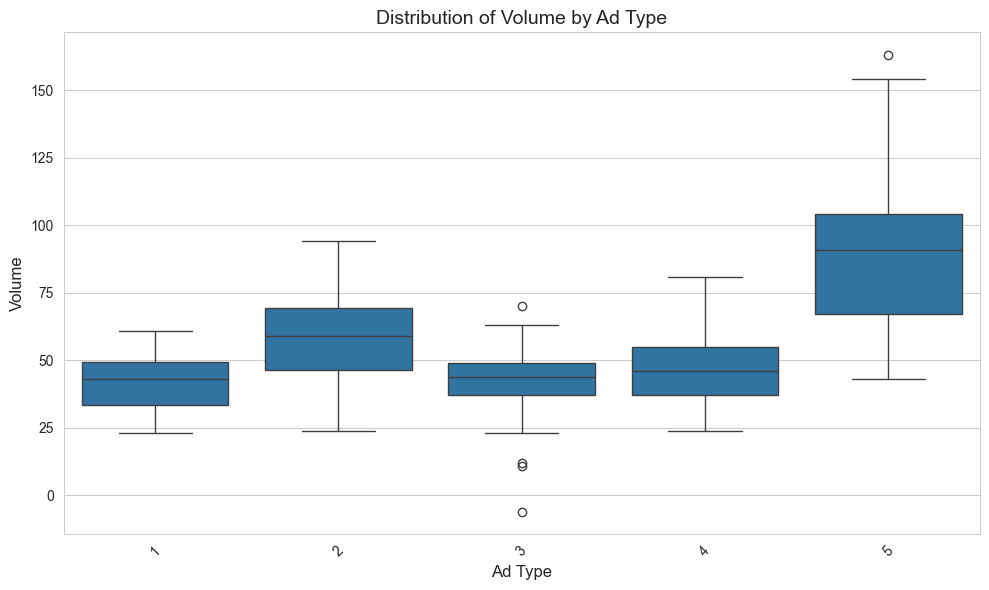

In [8]:
# Set the style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the boxplot
box_plot = sns.boxplot(x='ad', y='volume', data=df_volumes)

# Add title and labels
plt.title('Distribution of Volume by Ad Type', fontsize=14)
plt.xlabel('Ad Type', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

NOTE: for ad 3 there is a instance where the volume is negative (-6). Volume here is profit from click so it can be -ve as well. so, not cleaning this entry.

In [9]:
# df_volumes['volume'] = np.where(df_volumes['volume'] <0, 0, df_volumes['volume']) # Cleaning up the data 

In [10]:
df_T_rvs_base = df_vol_quantile[['count', 'mean', 'std']].rename(columns={'count': 'no.obs', 'mean': 'Mean', 'std': 'Std.Dev'}).reset_index()
df_T_rvs_base['Bayes.Posterior.df'] = df_T_rvs_base['no.obs'] + 1
df_T_rvs_base

,ad,no.obs,Mean,Std.Dev,Bayes.Posterior.df
0,1,52.0,42.076923,10.032977,53.0
1,2,38.0,57.289474,17.396657,39.0
2,3,51.0,41.803922,13.891033,52.0
3,4,45.0,47.888889,13.534841,46.0
4,5,25.0,90.640000,30.686425,26.0


In [11]:
df_T_rvs = pd.DataFrame() # data frame to store draw data for each ad base on the T distribution of the volume-per-click
draws = 100000 # Number of draws kept large to get better estimated 
_ismax_col_list = [] # list to store the ismax idetoifier columns to be used later

for i in range(1,df_T_rvs_base.ad.max()+1):
    _mean = df_T_rvs_base[df_T_rvs_base['ad']==i]['Mean'].values[0] # ads mean value
    _stddev = df_T_rvs_base[df_T_rvs_base['ad']==i]['Std.Dev'].values[0] # ads standard deviation
    # considering beta T Normal Distribution for Volumne per impression/clicks
    df_T_rvs[i] = list(scipy.stats.t.rvs(df=df_T_rvs_base[df_T_rvs_base['ad']==i]['Bayes.Posterior.df'], size=draws)) # T stats value based on the degree freedom for draws
    df_T_rvs[i] = (df_T_rvs[i] * _stddev) + _mean # ( T-value * std.dev ) + mean

df_T_rvs['max'] = df_T_rvs.max(axis=1) # max value of the draw among all ads

for i in range(1,df_T_rvs_base.ad.max()+1):
    df_T_rvs[f'ismax.{i}'] = np.where(df_T_rvs[i]==df_T_rvs['max'], 1, 0) # idetifiend the ad with volume-per-click each draw
    _ismax_col_list.append(f'ismax.{i}')

print("Number of Draws:", df_T_rvs.shape[0]) 
df_T_rvs.head(10)    

Number of Draws: 100000


,1,2,3,4,5,max,ismax.1,ismax.2,ismax.3,ismax.4,ismax.5
0,51.563837,69.857400,16.745664,57.975955,101.762539,101.762539,0,0,0,0,1
1,19.430208,50.465895,36.446716,28.329304,41.847230,50.465895,0,1,0,0,0
2,28.934466,52.514657,19.652919,38.560848,127.034268,127.034268,0,0,0,0,1
3,34.493028,55.247760,43.546902,62.132835,68.038630,68.038630,0,0,0,0,1
4,21.703443,62.884037,40.198435,54.740298,94.508087,94.508087,0,0,0,0,1
5,37.297236,45.396479,39.924177,61.346438,127.706522,127.706522,0,0,0,0,1
6,50.054054,65.295377,51.694823,45.213471,52.505470,65.295377,0,1,0,0,0
7,24.750596,45.393625,57.597943,50.894236,114.207379,114.207379,0,0,0,0,1
8,27.369914,44.981308,41.770284,67.249990,69.425769,69.425769,0,0,0,0,1
9,25.489823,65.925648,19.113757,59.892442,90.186661,90.186661,0,0,0,0,1


In [12]:
df_T_rvs_prob = df_T_rvs[_ismax_col_list].mean().reset_index().T # Identifing the distribution of the highest volume-per-clicks ad a.ka.a Prob of a volumne-per-click being the highest
df_T_rvs_prob.columns = df_T_rvs_prob.iloc[0]
df_T_rvs_prob = df_T_rvs_prob[1:]

assert np.isclose(df_T_rvs_prob.sum().sum(),1.0) # to check the prod distribution is summing close to 1

for i in range(1,df_T_rvs_base.ad.max()+1): # rename columns
    df_T_rvs_prob = df_T_rvs_prob.rename(columns={f"ismax.{i}": f"v.{i}"})

print("Probabilities of each ad being the highest profit from ad (Highest volume-per-impression rate)")
df_T_rvs_prob * 100.0 # just for output to show in percentage xx.xx % format

Probabilities of each ad being the highest profit from ad (Highest volume-per-impression rate)


index,v.1,v.2,v.3,v.4,v.5
0,1.161,13.856,2.208,4.479,78.296


Based on posterior probabilities of a ad campaines volume-per-click we see that 
- ad.5 is the most profitable conversion
- ad.2
- ad.4
- ad.3
- ad.1 is the least profitable conversion


#### Part 4.A.3 (True expected volume per exposure - impression)

In [13]:
# list of ads ID to loop through
_ad_list = list(range(1,df_T_rvs_base.ad.max()+1))
_ad_list

[1, 2, 3, 4, 5]

In [14]:
# check if ads click count match the volume data
for i in _ad_list:
    assert df_T_rvs_base[df_T_rvs_base.ad==i]['no.obs'].values[0] == df_clicks[df_clicks.ad==i]['clicks'].values[0]
    print(f"For ad {i}, click count matches volume data")

For ad 1, click count matches volume data
For ad 2, click count matches volume data
For ad 3, click count matches volume data
For ad 4, click count matches volume data
For ad 5, click count matches volume data


In [15]:
# concatenate clicks-per-exposure and volumn-per-click from above draw dataframes
df_combined = pd.concat(
    [ df_beta_rvs[_ad_list].rename(columns={i: f'c.{i}' for i in _ad_list}) # click-per-exposure (click-through-rate))
    , df_T_rvs[_ad_list].rename(columns={i: f'v.{i}' for i in _ad_list}) # volume-per-click
    ]
    , axis = 1
)

# apart from profit/volume per coversion and click-through-rate, 
# bid cost per click is also a factor while considering the profitability of any ad.
# so we need to subtract the bid cost per click from the vpe (Profit per expresion).
# Considering a constant and small value for Bid per click here and assuming all the ads have same bid cost per click
_bid_cost_per_click = 0.01 

_vpe_col_list = [] # list to store Volum-Per-Exposure (vpe) [clicks-per-exposure * volume-per-click]
for i in _ad_list: 
    df_combined[f'vpe.{i}'] = (df_combined[f'c.{i}'] * df_combined[f'v.{i}']) - (_bid_cost_per_click * df_combined[f'c.{i}'])
    _vpe_col_list.append(f'vpe.{i}')

df_combined['max'] = df_combined[_vpe_col_list].max(axis=1) # calculating the highest vpe of each draw

_ismax_col_list = [] # list to store the identifier for max vpe ad in each draw
for i in _ad_list:
    df_combined[f'ismax.{i}'] = np.where(df_combined[f'vpe.{i}']==df_combined['max'], 1, 0)
    _ismax_col_list.append(f'ismax.{i}')
    
df_combined


,c.1,c.2,c.3,c.4,c.5,v.1,v.2,v.3,v.4,v.5,...,vpe.2,vpe.3,vpe.4,vpe.5,max,ismax.1,ismax.2,ismax.3,ismax.4,ismax.5
0,0.054678,0.046691,0.054972,0.034130,0.038320,51.563837,69.857400,16.745664,57.975955,101.762539,...,3.261260,0.919988,1.978403,3.899196,3.899196,0,0,0,0,1
1,0.047209,0.043305,0.054104,0.047678,0.027224,19.430208,50.465895,36.446716,28.329304,41.847230,...,2.185005,1.971380,1.350202,1.138975,2.185005,0,1,0,0,0
2,0.051105,0.039907,0.063890,0.045728,0.019366,28.934466,52.514657,19.652919,38.560848,127.034268,...,2.095316,1.254989,1.762835,2.459911,2.459911,0,0,0,0,1
3,0.045406,0.033294,0.047365,0.049303,0.028927,34.493028,55.247760,43.546902,62.132835,68.038630,...,1.839093,2.062117,3.062831,1.967888,3.062831,0,0,0,1,0
4,0.057266,0.040667,0.049562,0.036819,0.017251,21.703443,62.884037,40.198435,54.740298,94.508087,...,2.556909,1.991803,2.015102,1.630175,2.556909,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.054267,0.038127,0.042407,0.051851,0.027350,37.606408,30.959416,34.615345,24.493422,50.080544,...,1.180013,1.467517,1.269486,1.369409,2.040238,1,0,0,0,0
99996,0.053659,0.046865,0.049317,0.044769,0.018265,63.234083,72.440848,54.023274,54.386162,120.842779,...,3.394463,2.663783,2.434360,2.207054,3.394463,0,1,0,0,0
99997,0.064483,0.040779,0.054932,0.043613,0.023948,59.598788,58.907398,43.982655,54.385274,92.637159,...,2.401752,2.415487,2.371488,2.218216,3.842462,1,0,0,0,0
99998,0.048317,0.037241,0.077910,0.040239,0.025884,37.780184,58.326119,47.803131,41.240099,116.473608,...,2.171765,3.723560,1.659062,3.014498,3.723560,0,0,1,0,0


In [16]:
df_exp_vpe_prob = df_combined[_ismax_col_list].mean().reset_index().T # prodbailty distribution of the Ad having the highest volume-per-exposure
df_exp_vpe_prob.columns = df_exp_vpe_prob.iloc[0]
df_exp_vpe_prob = df_exp_vpe_prob[1:]

assert np.isclose(df_exp_vpe_prob.sum().sum(),1.0) # to check the prod distribution is summing close to 1

for i in _ad_list: # rename columns
    df_exp_vpe_prob = df_exp_vpe_prob.rename(columns={f"ismax.{i}": f"EVI.{i}"})

print("Probability Distribution of Expected Volume/profit Per Exposure/impression")
df_exp_vpe_prob * 100.0 # just for output to show in percentage xx.xx % format

Probability Distribution of Expected Volume/profit Per Exposure/impression


index,EVI.1,EVI.2,EVI.3,EVI.4,EVI.5
0,16.37,20.201,18.33,17.507,27.592


Based on posterior probabilities of a ad campaines expected volume-per-exposure we see that 
- ad.5 is the highest profitable per exposure 
- ad.2 is the second highest profitable per exposure 
- ad.3 is the third highest profitable per exposure 
- ad.4 is the fourth highest profitable per exposure 
- ad.1 is the least profitable


#### Part 4.B

In [17]:
# order of Ads based on Exppected-volume-per-impression (EVI)
df_order_evi = df_exp_vpe_prob.T.reset_index().sort_values(by=0, ascending=False).rename(columns={0:'EVI','index':'Ad'}).reset_index(drop=True)
df_order_evi['Ad'] = df_order_evi['Ad'].str.replace('EVI.', '')
df_order_evi

,Ad,EVI
0,5,0.27592
1,2,0.20201
2,3,0.1833
3,4,0.17507
4,1,0.1637


In [18]:
# order of Ads based on Observed CTR cross Mean Volume of the ad ( Obs Volume per Impression)
df_order_obs_ctr_cross_mu_vol = np.multiply(df_T_rvs_base['Mean'], df_clicks['obs.ctr']).reset_index().sort_values(by=0, ascending=False).rename(columns={0:'Obs.ctr.cross.mu.vol','index':'Ad'}).reset_index(drop=True)
df_order_obs_ctr_cross_mu_vol = df_order_obs_ctr_cross_mu_vol.merge(df_clicks['obs.ctr'], left_on='Ad', right_index=True)
df_order_obs_ctr_cross_mu_vol = df_order_obs_ctr_cross_mu_vol.merge(df_T_rvs_base['Mean'], left_on='Ad', right_index=True)
df_order_obs_ctr_cross_mu_vol['Ad'] = df_order_obs_ctr_cross_mu_vol['Ad'] + 1
df_order_obs_ctr_cross_mu_vol[['Ad', 'obs.ctr', 'Mean', 'Obs.ctr.cross.mu.vol']]

,Ad,obs.ctr,Mean,Obs.ctr.cross.mu.vol
0,5,0.025,90.640000,2.266
1,1,0.052,42.076923,2.188
2,2,0.038,57.289474,2.177
3,4,0.045,47.888889,2.155
4,3,0.051,41.803922,2.132


We can clearly see the two orders are not same. Although the Higest profitable ad is still ad.5 the order for the next 4 is completly shuffled

**So, No — the two orderings need not agree. For ObservedCTR × MeanVolume order will vary every time we calculate a Summary Statistic with different sample data but the order for the probability of highest CTR × v will be almost same (given we have very large number of Monte Carlo draws)**


Having a larger *expected CTR × volume (i.e., ObservedCTR × MeanVolume)* for campaign A than for campaign B does **not** guarantee that A has a greater probability of *being the top performer* (i.e. \( P(A > B) > 0.5 \)).  
The expectation alone omits information about distributional shape (variance, skewness, and tails), and those aspects affect probabilities.

#### Intuition

Comparing expectations gives only a single summary statistic.  
The event \( X > Y \) depends on the entire distributions of \( X \) and \( Y \).  
A random variable \( X \) can have a higher mean than \( Y \) because it occasionally takes very large values with tiny probability; yet most of the time, \( X \) is smaller than \( Y \).

Thus, it is possible for \( E[X] > E[Y] \) but \( P(X > Y) < 0.5 \).

---

#### Concrete Counterexample (Independent Variables)

Let

X = 100 (with probability :  0.01), 0 (with probability :  0.99)

so E[X] = 100 * 0.01 = 1.

Let ( Y = 0.6 ) (constant), so ( E[Y] = 0.6 )

Then ( E[X] > E[Y] ), but [ P(X > Y) = P(X = 100) = 0.01 and P(Y > X) = 0.99 ]

Hence ( P(X > Y) << 0.5 ) even though ( E[X] > E[Y] )

---

#### Implication for Campaigns

A campaign may have a slightly larger ObservedCTR × MeanVolume because it occasionally produces very large CTR × v outcomes (rare but big), while another campaign is steadier with moderate results.  
The first campaign can have a higher *expected* metric but a lower *probability of being the best* in head-to-head comparisons.

---

#### When Expectations Do Imply Same Ordering

Agreement occurs only under stronger conditions, such as:

- **First-order stochastic dominance:**  
  If ( F_X(t) < F_Y(t) ) for all t, then ( P(X > Y) > 0.5 ) and ( E[X] > E[Y] )
- **Same location-scale family:**  
  If ( X ) and ( Y ) differ only by a location shift (e.g., normal distributions with same variance), then a higher mean implies a higher chance of winning.

But in general, **expectation alone is insufficient** to guarantee ( P(X > Y) > 0.5 ).

---

#### Conclusion

Because the probability of being the highest depends on full distributions (not just means),  
the ordering by **probability of highest CTR × v** can differ from the ordering by **ObservedCTR × MeanVolume**.  
Even with a huge number of Monte Carlo draws (negligible simulation error),  
differences in variance or tail behavior can lead to distinct orderings.
